<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/environment_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 周辺環境スコア
- input
    - park_score.csv
        - 公園スコア
    - sports_score.csv
        - 運動場スコア
        - 体育館スコア
        - プールスコア
- output
    - environment_score.csv
        - 周辺環境スコア


In [1]:
!pip install -q japanize-matplotlib

     |████████████████████████████████| 4.1 MB 5.0 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
score_name = '周辺環境スコア'
output_score_file = 'environment_score.csv'

### 人口マスタ

In [6]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[[
    '地域ID', '市区町村名', '町名', '町丁目'
]].set_index('地域ID')
print(df_pop_master.shape)

(3145, 3)


### 公園スコア

In [7]:
df_park_score = pd.read_csv(os.path.join(DIR_NAME, 'park_score.csv'))[[
    '地域ID', '公園スコア',
]].set_index('地域ID')
print(df_park_score.shape)

(3145, 1)


In [8]:
df_park_score.head()

,公園スコア
地域ID,
101003,1.882
101004,1.830
101005,1.793
101007,1.926
101008,1.987


### スポーツ施設

In [9]:
df_sports_score = pd.read_csv(os.path.join(DIR_NAME, 'sports_score.csv'))[[
    '地域ID', '運動場スコア', '体育館スコア', 'プールスコア',
]].set_index('地域ID')
print(df_sports_score.shape)

(3145, 3)


In [10]:
df_sports_score.head()

,運動場スコア,体育館スコア,プールスコア
地域ID,,,
101003,1.628,3.109,3.164
101004,1.412,2.949,3.026
101005,1.198,2.468,2.861
101007,1.597,3.907,3.907
101008,1.924,4.108,4.026


In [11]:
import numpy as np
from scipy.stats import norm

def rank_score(sr_data):
    count = len(sr_data)
    rank = sr_data.rank()
    x = (rank + 1)/(count + 1)
    max_val = 5
    y = norm.ppf(x, loc=0.5, scale=0.14)*max_val
    return np.clip(y, 0, max_val)

### 周辺環境スコア

In [12]:
df_score = pd.concat([
    df_pop_master,
    df_park_score,
    df_sports_score
], axis=1)
print(df_score.shape)
assert len(df_score) == len(df_pop_master)
df_pop_master = df_score

(3145, 7)


In [13]:
print(df_pop_master.shape)
df_pop_master.head()

(3145, 7)


,市区町村名,町名,町丁目,公園スコア,運動場スコア,体育館スコア,プールスコア
地域ID,,,,,,,
101003,千代田区,丸の内,丸の内１丁目,1.882,1.628,3.109,3.164
101004,千代田区,丸の内,丸の内２丁目,1.830,1.412,2.949,3.026
101005,千代田区,丸の内,丸の内３丁目,1.793,1.198,2.468,2.861
101007,千代田区,大手町,大手町１丁目,1.926,1.597,3.907,3.907
101008,千代田区,大手町,大手町２丁目,1.987,1.924,4.108,4.026


In [14]:
feature_list = {
    '公園スコア': {'sort': 1, 'weight': 1},
    '運動場スコア': {'sort': 1, 'weight': 0.3},
    '体育館スコア': {'sort': 1, 'weight': 0.3},
    'プールスコア': {'sort': 1, 'weight': 0.3},
}

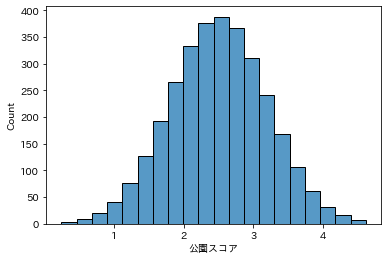

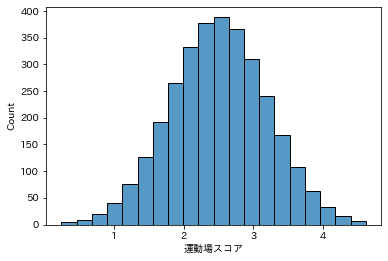

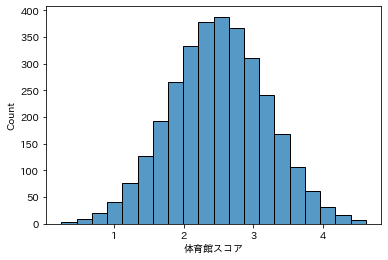

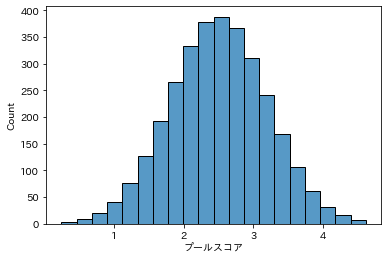

In [15]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

In [16]:
score_list = []
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = rank_score(df_pop_master[key] * value['sort'])
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1) # skipna=False
df_pop_master[score_name] = rank_score(_tmp_score)

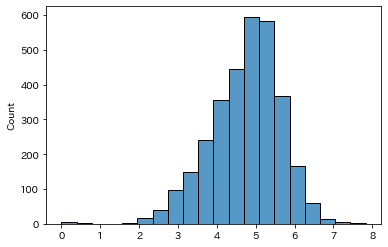

In [17]:
sns.histplot(_tmp_score, bins=20)
plt.show()

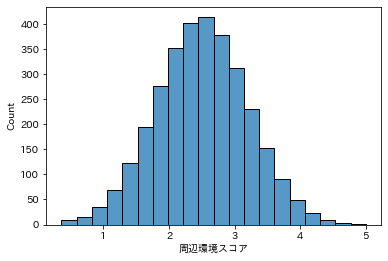

In [18]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

In [19]:
df_pop_master[score_name].describe()

count    3145.000000
mean        2.501569
std         0.698611
min         0.359103
25%         2.028907
50%         2.500558
75%         2.972493
max         5.000000
Name: 周辺環境スコア, dtype: float64

In [20]:
df_pop_master[score_name] = df_pop_master[score_name].round(3)

In [21]:
df_pop_master[
    list(feature_list.keys()) + [score_name]
].to_csv(os.path.join(DIR_NAME, output_score_file), index=True)

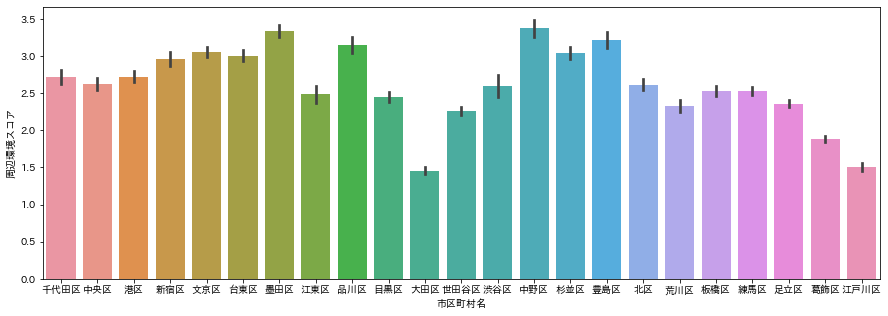

In [22]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y=score_name, data=df_pop_master)
plt.show()

In [23]:
df_level = df_pop_master.copy()
df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
    ['市区町村名', '町名', '町丁目'] + list(feature_list.keys()) + [score_name]
].reset_index(drop=True)
print(df_level.shape)

(912, 8)


In [24]:
df_level.head(10)

,市区町村名,町名,町丁目,公園スコア,運動場スコア,体育館スコア,プールスコア,周辺環境スコア
0,新宿区,百人町,百人町４丁目,4.525,4.064,3.831,3.117,5.000
1,新宿区,上落合,上落合１丁目,4.491,4.014,2.893,2.568,4.756
2,中野区,東中野,東中野５丁目,4.613,3.623,2.882,2.532,4.673
3,新宿区,高田馬場,高田馬場４丁目,4.244,3.520,3.688,3.044,4.613
4,新宿区,北新宿,北新宿４丁目,4.461,3.390,3.038,2.668,4.565
5,品川区,戸越,戸越２丁目,4.270,2.261,3.631,2.967,4.491
6,品川区,豊町,豊町１丁目,4.349,2.444,3.347,2.716,4.461
7,江東区,亀戸,亀戸４丁目,4.141,3.253,3.300,2.464,4.434
8,豊島区,上池袋,上池袋１丁目,4.434,2.679,2.680,2.597,4.410
9,杉並区,高円寺南,高円寺南１丁目,3.951,3.172,3.171,2.976,4.388


In [25]:
df_level.tail(10)

,市区町村名,町名,町丁目,公園スコア,運動場スコア,体育館スコア,プールスコア,周辺環境スコア
902,大田区,東六郷,東六郷１丁目,0.822,2.227,2.160,2.043,1.076
903,大田区,羽田空港,羽田空港１丁目,1.058,2.011,1.401,1.917,1.034
904,大田区,仲六郷,仲六郷１丁目,0.884,2.026,2.095,1.785,1.029
905,大田区,南六郷,南六郷１丁目,0.566,2.704,1.938,2.218,0.997
906,大田区,西六郷,西六郷１丁目,0.929,1.852,1.829,1.894,0.991
907,江戸川区,堀江町,堀江町,1.365,1.458,1.344,1.003,0.915
908,江戸川区,西瑞江,西瑞江５丁目,0.907,1.684,1.846,1.757,0.900
909,江東区,若洲,若洲１丁目,1.596,0.986,0.539,0.387,0.701
910,大田区,羽田沖水面,羽田沖水面,NaN,NaN,NaN,NaN,0.359
911,大田区,ふるさとの浜辺公園,ふるさとの浜辺公園,NaN,NaN,NaN,NaN,0.359
